# Sunspots Estimator Using a Conv Net

A convolutional neural network do predict the number of sunspots active in the Sun monthly average.

Import required modules.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

print(tf.__version__)  # tensorflow version 2 required

2.0.0-rc1


Do some initial setup.

In [2]:
# set seaborn graphs figure size
sns.set(rc={'figure.figsize':(16,8)})

# hide warnings
warnings.filterwarnings('ignore')

## The Dataset

Get the number of sunspots data from the [y-space](http://y-space.pw) API and store it in a JSON filw.

In [3]:
!wget --quiet http://api.y-space.pw/sunspots/monthly -O monthly.json

Import the data to a pandas dataframe.

In [4]:
# read from json file
df_monthly = pd.read_json('monthly.json')

# update columns order
cols_monthly = ['year','month','fraction','mean','sd','observations','final']
df_monthly = df_monthly.reindex(columns=cols_monthly)

# inspect the first rows
df_monthly.head()

,year,month,fraction,mean,sd,observations,final
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


Plot the number of sunsplots in the dataset.

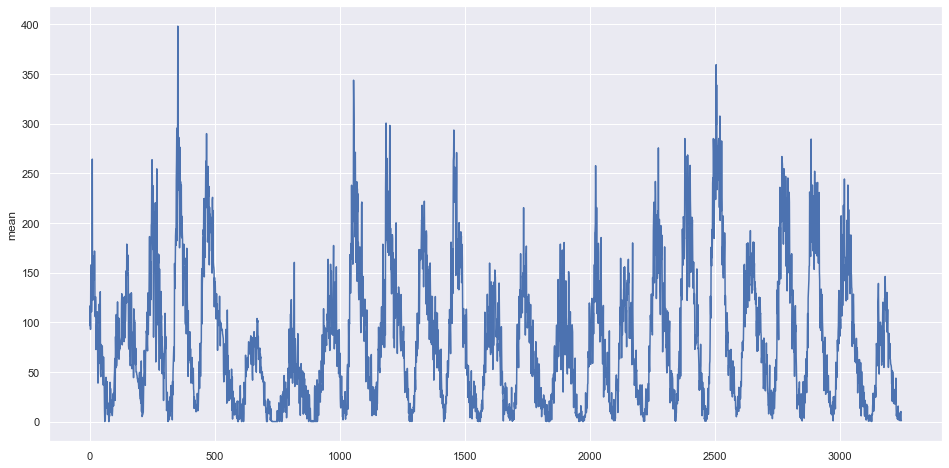

In [5]:
sns.lineplot(x=range(len(df_monthly)), y=df_monthly['mean'])

In [6]:
series = df_monthly['mean'].to_numpy()
time   = np.array(range(len(df_monthly)))

print(series.shape, time.shape)  # (3247,) (3247,)

(3247,) (3247,)


Split the series data in two sets: training and validation.

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train    = series[:split_time]
time_valid = time[split_time:]
x_valid    = series[split_time:]

Set some global parameters: the window size to divide the data poits, and the batch size to train the model.

In [8]:
window_size = 60
batch_size  = 100
shuffle_buffer_size = 1000

Define a function that returns the training data divided in batches.

In [9]:
def batch_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(1)

Define the final training set.

In [10]:
train_set = batch_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build and Train the model

The model is composed of a convolutional layer with 32 filters, two LSTM layers with 60 nodes, two fully connected layers with 20 and 10 nodes with _relu_ activation and the final output layer has 1 single node.

In [11]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(name='conv-1', filters=32, kernel_size=5,
                         strides=1, padding="causal", activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, name='lstm-1', return_sequences=True),
  tf.keras.layers.LSTM(60, name='lstm-2', return_sequences=True),
  tf.keras.layers.Dense(20, name='fc-1', activation="relu"),
  tf.keras.layers.Dense(10, name='fc-2', activation="relu"),
  tf.keras.layers.Dense(1, name='output')
])

In [12]:
# inspect the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv-1 (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm-1 (LSTM)                (None, None, 60)          22320     
_________________________________________________________________
lstm-2 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
fc-1 (Dense)                 (None, None, 20)          1220      
_________________________________________________________________
fc-2 (Dense)                 (None, None, 10)          210       
_________________________________________________________________
output (Dense)               (None, None, 1)           11        
Total params: 52,993
Trainable params: 52,993
Non-trainable params: 0
____________________________________________________

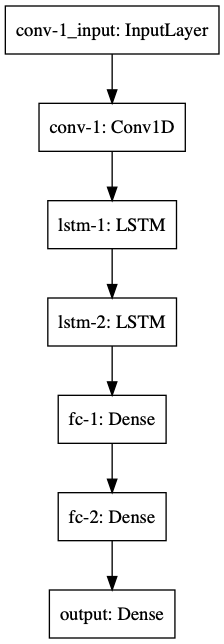

In [13]:
# plot the layers sequence
tf.keras.utils.plot_model(model)

Finally the model is trained using a Stochastic Gradient Descent optimizer, using a learning rate of 1e-5 and a momentum of 0.9 and an Huber loss function, during 500 epochs.

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=500)

## Predictions

To have an idea of the model accuracy we predict the models for the entire series.

In [15]:
ds = tf.data.Dataset.from_tensor_slices(series[..., np.newaxis])
ds = ds.window(window_size, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda w: w.batch(window_size))
ds = ds.batch(batch_size).prefetch(1)

forecasts = model.predict(ds)
forecasts = forecasts[:-1, -1, 0]

Plot the predictions (orange line) versus the real values (blue line).

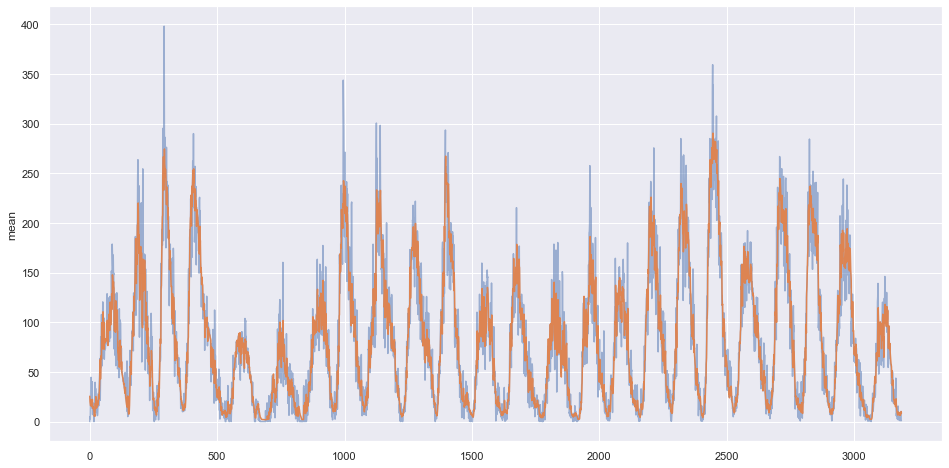

In [16]:
sns.lineplot(x=range(len(forecasts)), y=df_monthly['mean'][window_size:], alpha=0.5)
sns.lineplot(x=range(len(forecasts)), y=forecasts)

## Save the model

In [17]:
model.save('sunspots-estimator.h5')